# Sprint 3 Presentation

## Sprint Objectives

* Create and tune the following models:
    * ARIMA
    * Prohpet
    * Decision Trees
* Evaluate model performance and compare different approaches
    * standardise evaluation against train/validation split
    * build reusable code for this
    * how close are we to competitive, what would we need to get there?
* Agile ways of working
    * Build reusable code
        * modular
        * organized
        * commented
        * accessible on git
    * define and adhere to role responsibilities


In [1]:
# Imports

# Standard Imports
import importlib
import os
import numpy as np
import pandas as pd
import sys

# modelling
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.stattools import kpss

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


# Src modules
sys.path.append(os.path.dirname(os.getcwd())) # Add the parent directory to the Python path so we can import src modules
import src
importlib.reload(src)
from src.arima import arima_trial
from src.data_setup import get_data, train_val_split, get_oil_holiday_data, RAW_PATH, RESULTS_PATH
from src.model_evaluation import model_eval_pipeline, eval_hypothesis_test
from src.visualisation import plot_heatmap, plot_sales_by, plot_time_series_preds, plot_rolling_average_stdev

In [2]:
# load in dataframes
train, test, stores, transactions = get_data()
# merge stores data into train
train = train.merge(stores, on ='store_nbr')
# this arima model will be looking at daily sales so we have to aggregate away from store number and family
daily_sales = train.groupby('date')['sales'].sum().reset_index()

loading pickled dataframes...


# Seasonality EDA

In [3]:
# sales over time
px.line(daily_sales, x='date', y='sales',title = "Daily Sales over Time")

In [30]:
# examine sales by category
for col in ['store_nbr', 'family']:
    plot_sales_by(train, col)

In [5]:
# Plot daily sales by year and day of the week
grouped = train.groupby(['year', 'day_of_week'])['sales'].mean().reset_index()

# Create a line chart
fig = px.line(grouped, x="day_of_week", y="sales" , color="year", title="Average sales by year and day_of_week")
# Set xticks
fig.update_layout(
    xaxis=dict(
        tickvals=list(range(1, 8)),  # Specify tick values
        ticktext=['mon', 'tues', 'weds', 'thurs', 'fri', 'sat', 'sun']  # Specify tick labels
    )
)
# Show the chart
fig.show()

The data exhibits a trend by day of the week

In [6]:
# Plot daily sales by month and day of the week
grouped = train.groupby(['month', 'day_of_week'])['sales'].mean().reset_index()

# Create a line chart
fig = px.line(grouped, x="day_of_week", y="sales" , color="month", title="Average sales by month and day_of_week")

# Set xticks
fig.update_layout(
    xaxis=dict(
        tickvals=list(range(1, 8)),  # Specify tick values
        ticktext=['mon', 'tues', 'weds', 'thurs', 'fri', 'sat', 'sun']  # Specify tick labels
    )
)
# Show the chart
fig.show()

Within any given month, the same weekly trend appears to hold true.

In [7]:
# plot a heatmap to see how the families behave on different days of the week
plot_heatmap(train, 'family', 'day_of_week')

In [8]:
# plot a heatmap to see how the families behave on different months
plot_heatmap(train, 'family', 'month')

In [9]:
# heatmap by store_nbr and month
plot_heatmap(train, 'store_nbr', 'month')

In [10]:
# heatmap by store_nbr and day of week
plot_heatmap(train, 'store_nbr', 'day_of_week')

In [11]:
# plot family and store_nbr heatmap
plot_heatmap(train, 'family', 'store_nbr')

In [12]:
# heatmap by store_nbr and family
plot_heatmap(train, 'store_nbr', 'family')

In [13]:
# heatmap by family and store_nbr
plot_heatmap(train, 'family', 'store_nbr')

# ARIMA

## Autocorrelation
Auto-Correlation Function(ACF) - Correlation between the original data and the same data lagged by ‘h’ time period

Normally in an ARIMA model, we make use of either the AR term or the MA term. We use both of these terms only on rare occasions. We use the ACF plot to decide which one of these terms we would use for our time series

If there is a Positive autocorrelation at lag 1 then we use the AR model

If there is a Negative autocorrelation at lag 1 then we use the MA model

In [14]:
# lag of one autocorrelation
sales_series = daily_sales['sales']
print(f'Autocorrelation at a lag of 1: {sales_series.autocorr():.4f}')

Autocorrelation at a lag of 1: 0.7669


because the autocorr coefficient is positive for lag 1 we will use an autoregressive model.  

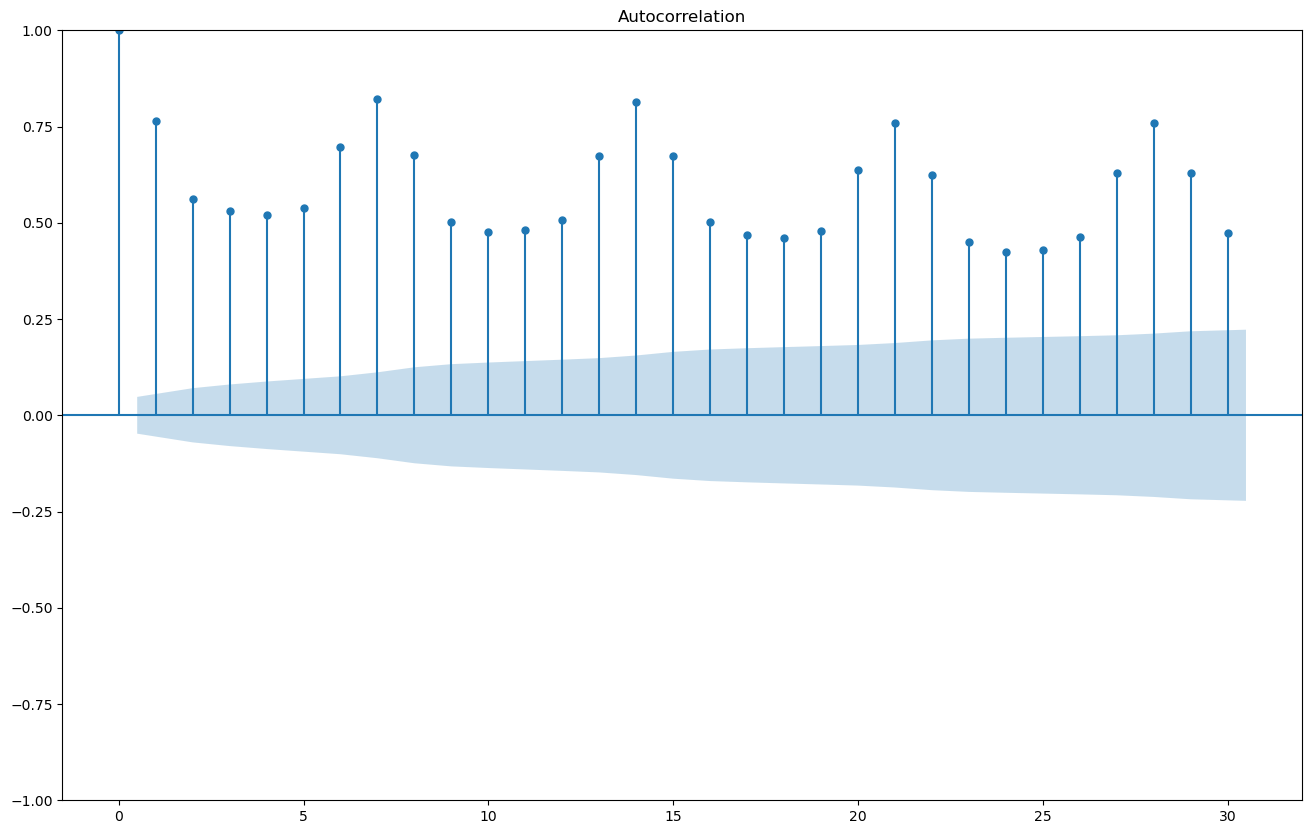

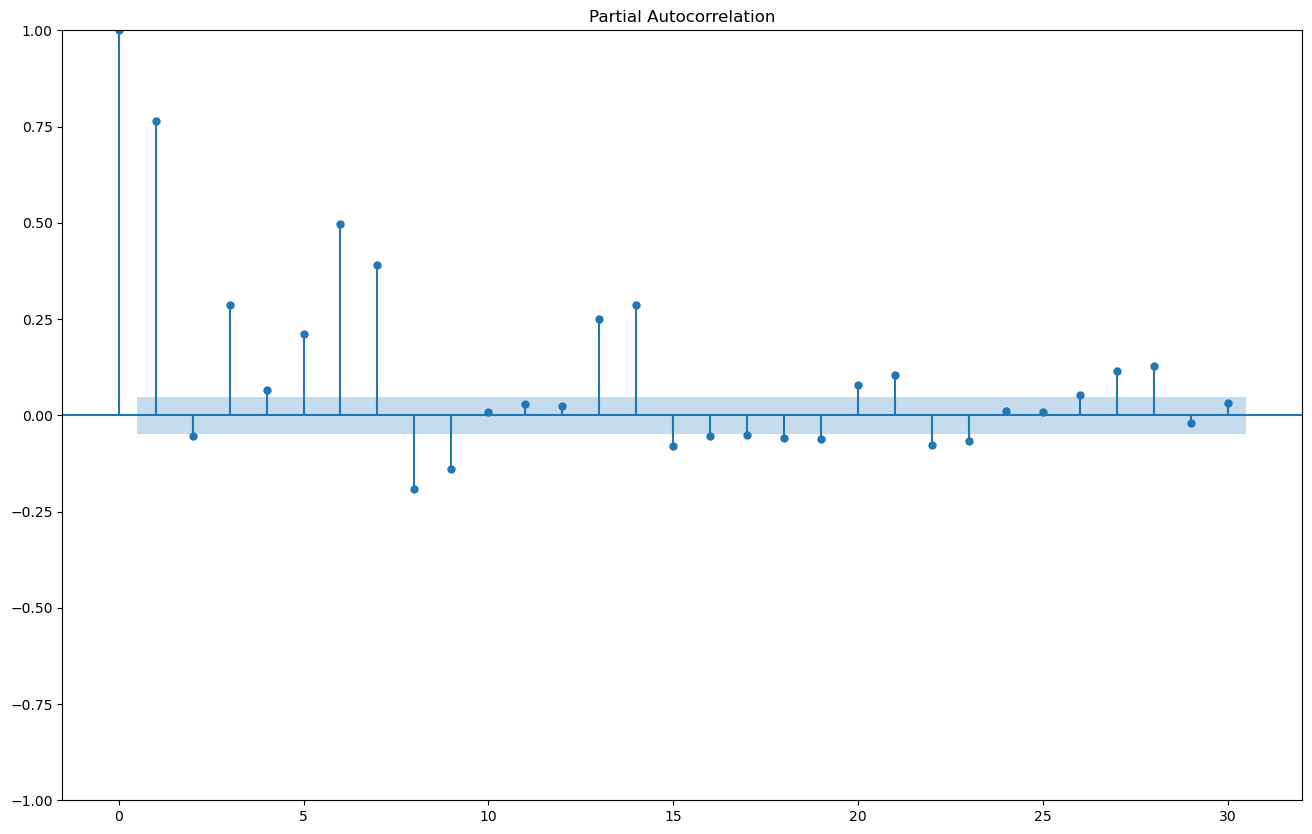

In [15]:
fig, ax = plt.subplots(figsize=(16, 10))
acf = plot_acf(sales_series, lags=30, ax=ax)
fig, ax = plt.subplots(figsize=(16, 10))
pacf = plot_pacf(sales_series, lags=30, method='ywm', ax=ax)   # added method to get rid of a future warning

## Stationarity Test

If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast. 

Stationary time series is when the mean and variance are constant over time. It is easier to predict when the series is stationary.

Differencing is a method of transforming a non-stationary time series into a stationary one. This is an important step in preparing data to be used in an ARIMA model.

H0: the data is not stationary (mean and variance are not constant over time)
H1: the data is stationary (mean and variance are constant over time)

In [16]:
# visualise the rolling average and standard deviation of the daily sales
plot_rolling_average_stdev(daily_sales)

In [17]:
# hypothesis test for stationarity
df_hypotheses = [
    'data is not stationary',   # null hypothesis
    'data is stationary'        # alternate hypothesis
]
# Dickey-Fuller Test for Stationarity
dickey_fuller = adfuller(sales_series)
eval_hypothesis_test(df_hypotheses, dickey_fuller[1])

Fail to reject the null hypothesis: "data is not stationary" (p-value: 0.0897)


Since we fail to reject the null hypothesis, we perform differencing until the data is stationary

In [18]:
# difference the sales
daily_sales['diff_sales'] = daily_sales['sales'].diff()
daily_sales = daily_sales.dropna()

In [19]:
# visualise stationarity
plot_rolling_average_stdev(daily_sales, col='diff_sales')

The rolling agerage and standard deviation are visually more constant now

In [20]:
# hypothesis test for stationarity again
dickey_fuller = adfuller(daily_sales['diff_sales'])
eval_hypothesis_test(df_hypotheses, dickey_fuller[1])

Reject the null hypothesis, accept alternate hypothesis: "data is stationary" (p-value: 0.0000)


The data is now stationary so we can proceed with the modelling. First lets review the autocorrelation plots on the differenced data. 

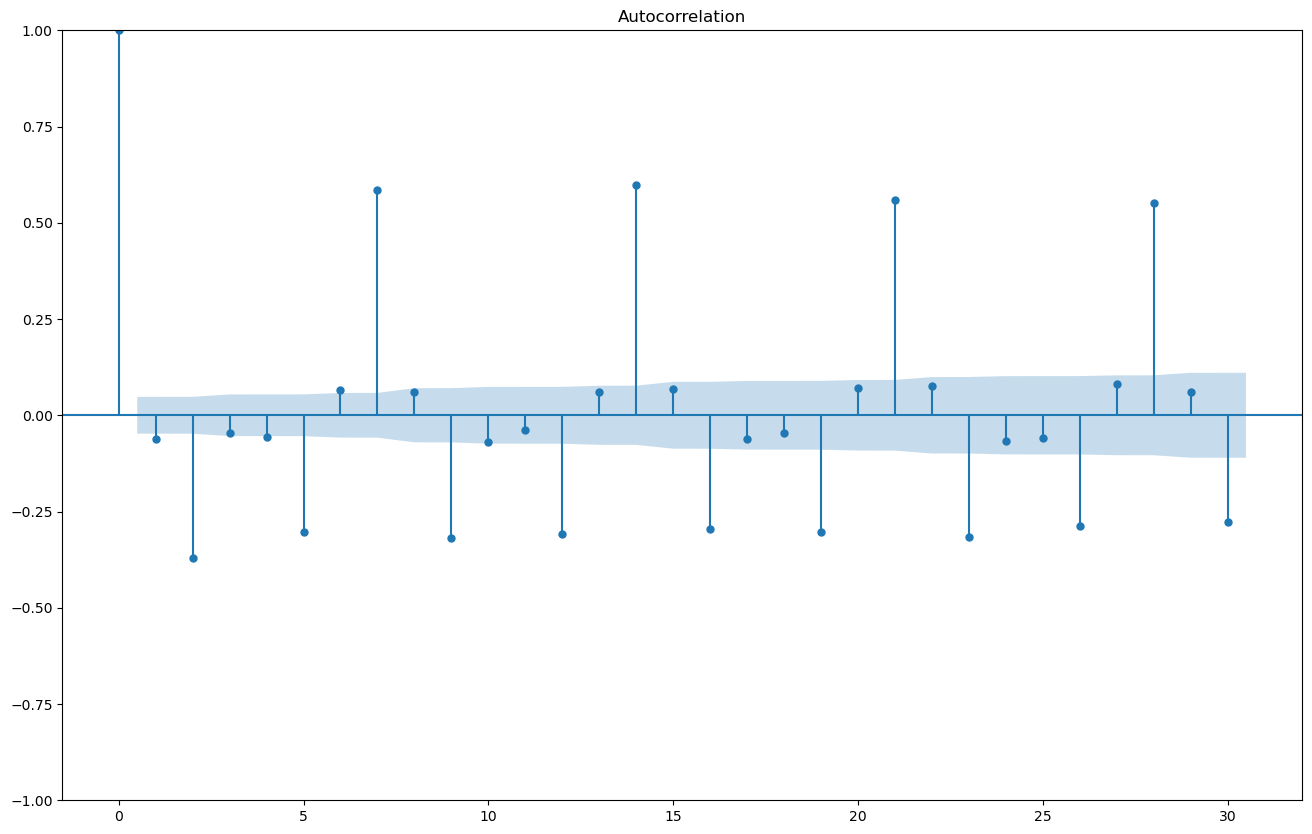

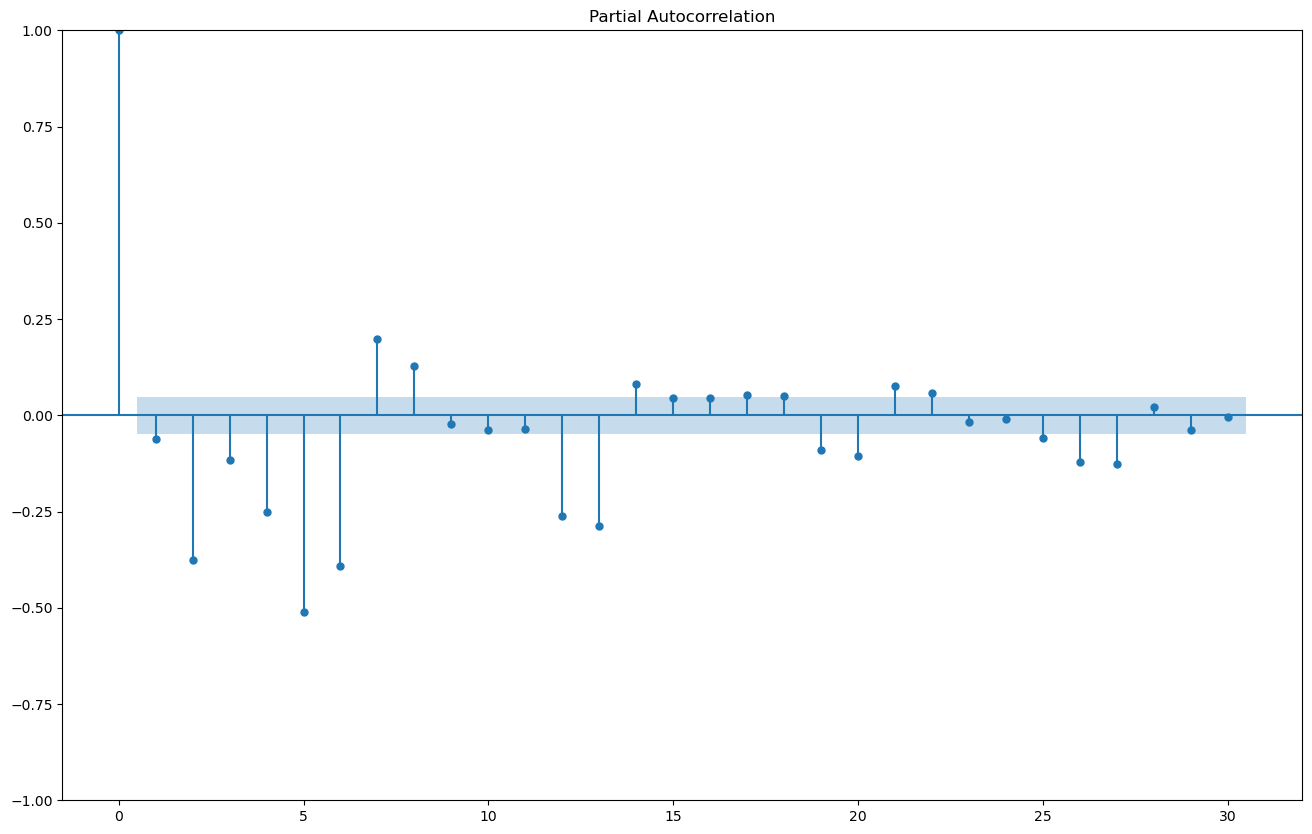

In [21]:
fig, ax = plt.subplots(figsize=(16, 10))
acf = plot_acf(daily_sales['diff_sales'], lags=30, ax=ax)
fig, ax = plt.subplots(figsize=(16, 10))
pacf = plot_pacf(daily_sales['diff_sales'], lags=30, method='ywm', ax=ax)   # added method to get rid of a future warning

Autocorrelation has peaks every 7 days, which makes sense that the data would have a weekly trend. 

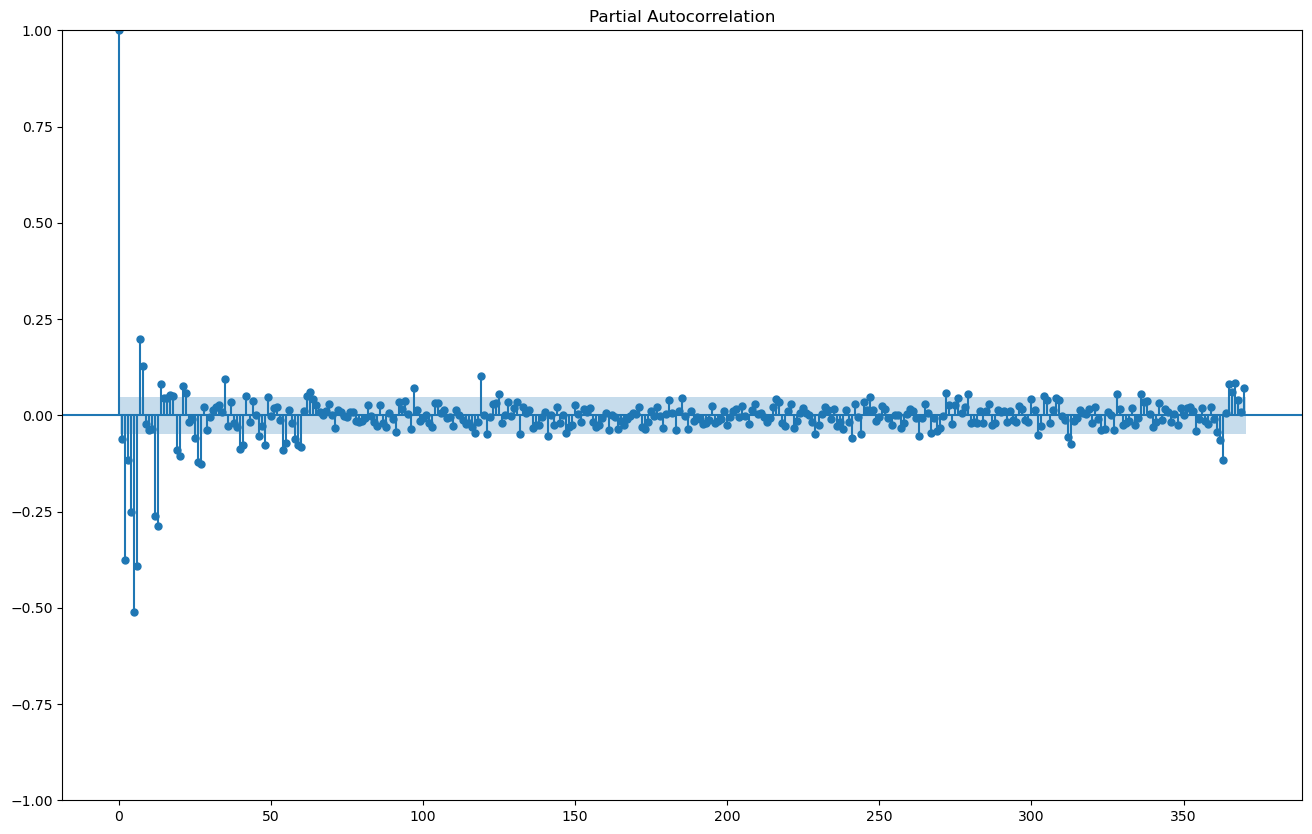

In [22]:

acf = plot_acf(daily_sales['diff_sales'], lags=370, ax=ax)
fig, ax = plt.subplots(figsize=(16, 10))
pacf = plot_pacf(daily_sales['diff_sales'], lags=370, method='ywm', ax=ax)   # added method to get rid of a future warning

## Building the ARIMA Model

In [23]:
# split into train and validation data
train_daily_sales, valid_daily_sales = train_val_split(daily_sales)
X_train = train_daily_sales['diff_sales'].values   # pass the differenced sales numbers to the arima model
X_valid = valid_daily_sales['diff_sales'].values

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1654
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -22666.562
Date:                Tue, 13 Jun 2023   AIC                          45337.124
Time:                        15:48:31   BIC                          45347.945
Sample:                             0   HQIC                         45341.136
                               - 1654                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3554      0.012    -30.219      0.000      -0.378      -0.332
sigma2      4.754e+10   1.11e-13   4.27e+23      0.000    4.75e+10    4.75e+10
Ljung-Box (L1) (Q):                  47.89   Jarque-

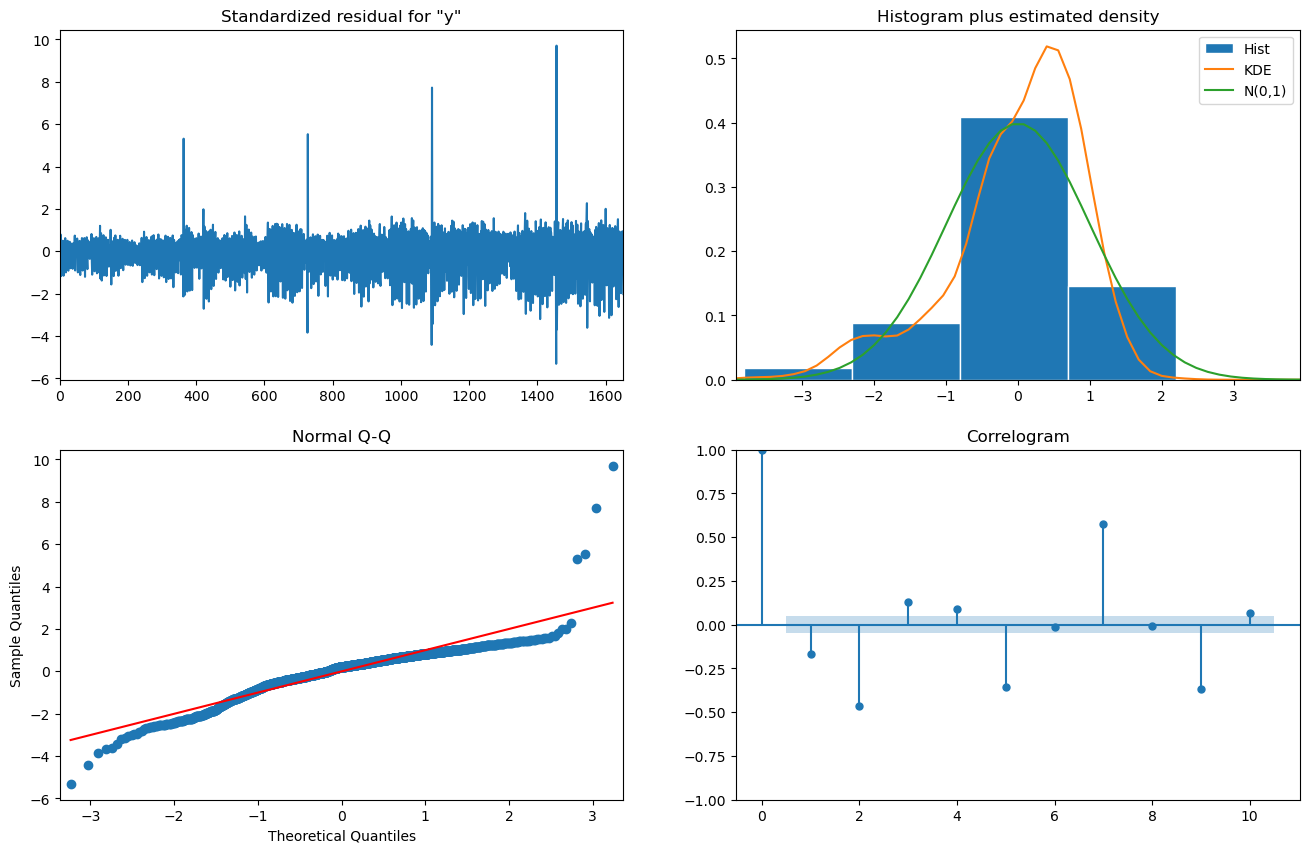

In [24]:
# basic arima
valid_result = arima_trial(X_train, X_valid, pdq_order=(1, 1, 0), plots=True, date_series=train_daily_sales['date'], show_summary=True)

### Seasonal ARIMA

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1654
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -21639.461
Date:                           Tue, 13 Jun 2023   AIC                          43288.923
Time:                                   15:48:34   BIC                          43315.953
Sample:                                        0   HQIC                         43298.946
                                          - 1654                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2971      0.021    -14.180      0.000      -0.338      -0.256
ma.L1         -0.9986      0.023    -42.598

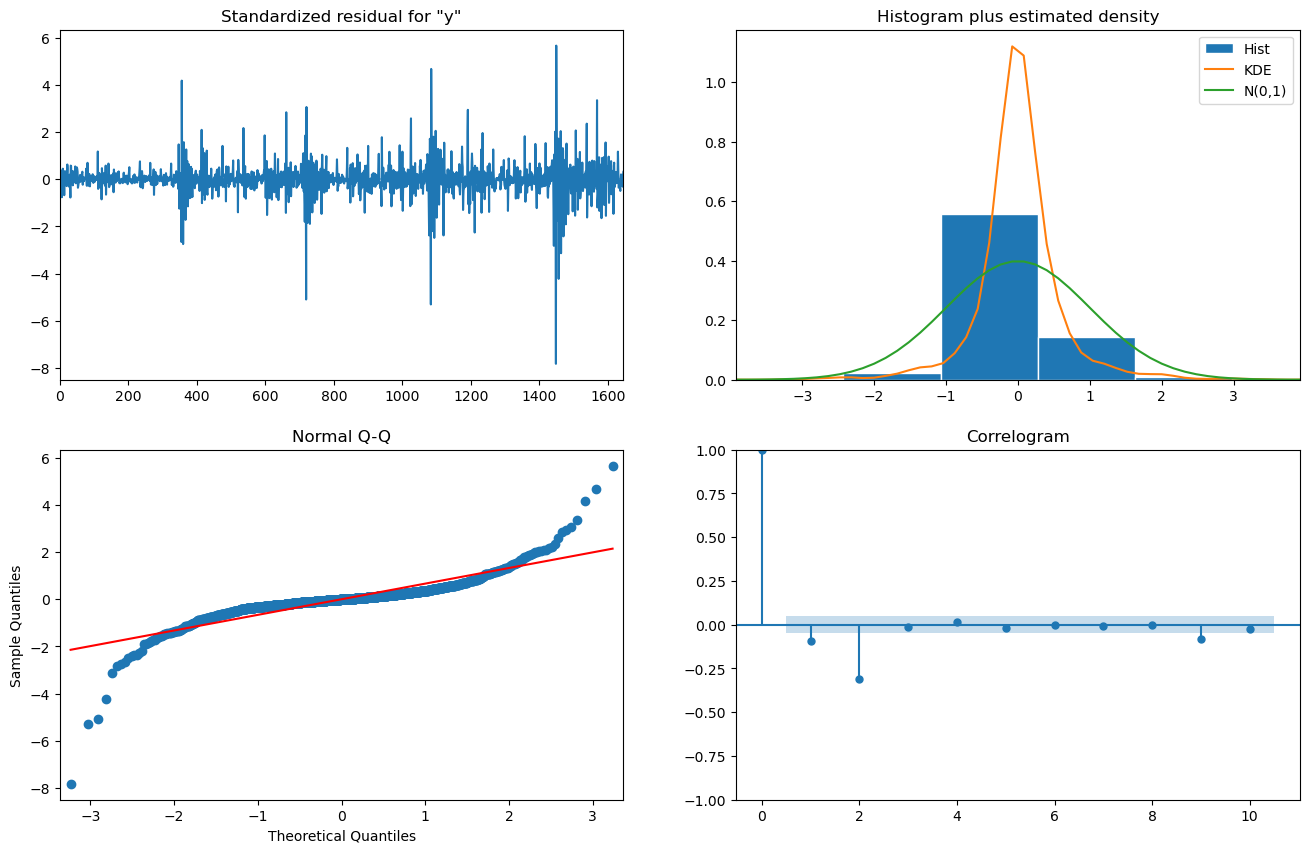

In [25]:
# seasonal arima model
valid_result = arima_trial(X_train, X_valid, pdq_order=(1, 1, 1), seasonal_order=(1, 1, 1, 7), plots=True, date_series=train_daily_sales['date'], show_summary=True)

In [26]:
# Turn differenced sales into actual sales

# Retrieve the last value of the original series
last_original_value = train_daily_sales['sales'].iloc[-1]

# Reverse the differencing and obtain actual predictions
valid_result['pred_sales'] = (valid_result['pred_diff_sales'].cumsum() + last_original_value)

# add day of week feature
valid_result['day_of_week'] = valid_result.date.dt.isocalendar().day.astype("int8")

plot_time_series_preds(valid_daily_sales['date'], preds=[valid_daily_sales['sales'], valid_result['pred_sales']], col='Sales')

# Prophet

In [27]:
# plot prophet results
prophet_result = pd.read_pickle(RESULTS_PATH / 'prophet_results.pkl')
plot_time_series_preds(valid_daily_sales['date'], preds=[valid_daily_sales['sales'], prophet_result['pred']], col='Sales')

# Decision Trees

In [28]:
# plot decision tree results
dt_result = pd.read_pickle(RESULTS_PATH / 'DT_results.pkl')
dt_preds = dt_result.query('Dataset=="gbr_pred"')
plot_time_series_preds(valid_daily_sales['date'], preds=[valid_daily_sales['sales'], dt_preds['sales']], col='Sales')

# Overall Comparison

In [29]:
# compare all models
models = [
    'Actual',
    'ARIMA',
    'Decision Tree',
    'Prophet',
]
preds = [
    valid_daily_sales['sales'],
    valid_result['pred_sales'],
    dt_preds['sales'],
    prophet_result['pred'],
]

plot_time_series_preds(valid_daily_sales['date'], preds=preds,names=models, col='Sales')

# Next Steps

* Review Approaches as a team
* tune models
* look into ensembles
* kaggle sumbissions!